# Currency Exchange Rate Prediction

In [154]:
import warnings
warnings.filterwarnings('ignore')

## Importing Libraries

In [155]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import keras
keras.utils.set_random_seed(1)
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Downloading the historical Currency Data from Yahoo Finance

In [156]:
start_date = datetime(2014, 1, 1)
end_date = datetime(2024, 8, 1)

currency = 'GBPUSD'
df = yf.download(currency+'=X', start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed


## Exploratory Data Analysis (EDA)

In [157]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,1.656397,1.656397,1.656397,1.656397,1.656397,0
2014-01-02,1.657660,1.660495,1.642387,1.658072,1.658072,0
2014-01-03,1.645007,1.647501,1.640070,1.644791,1.644791,0
2014-01-06,1.641201,1.643304,1.634254,1.641309,1.641309,0
2014-01-07,1.641497,1.643548,1.637546,1.641794,1.641794,0


In [158]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-07-25,1.289840,1.291339,1.286289,1.289990,1.289990,0
2024-07-26,1.285562,1.287498,1.285050,1.285678,1.285678,0
2024-07-29,1.286720,1.288843,1.280705,1.286836,1.286836,0
2024-07-30,1.285793,1.286505,1.282101,1.286041,1.286041,0
2024-07-31,1.283812,1.285446,1.282249,1.283697,1.283697,0


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2758 entries, 2014-01-01 to 2024-07-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2758 non-null   float64
 1   High       2758 non-null   float64
 2   Low        2758 non-null   float64
 3   Close      2758 non-null   float64
 4   Adj Close  2758 non-null   float64
 5   Volume     2758 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 150.8 KB


In [160]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.0
mean,1.352679,1.357315,1.347714,1.352698,1.352698,0.0
std,0.132837,0.132529,0.133097,0.132838,0.132838,0.0
min,1.072846,1.083541,1.037904,1.072754,1.072754,0.0
25%,1.261279,1.265090,1.256949,1.261380,1.261380,0.0
50%,1.310049,1.314458,1.305492,1.310221,1.310221,0.0
75%,1.408446,1.413827,1.402269,1.408525,1.408525,0.0
max,1.716237,1.718715,1.714237,1.716090,1.716090,0.0


In [161]:
df.shape

(2758, 6)

### Plotting the closing price of GBP/USD exchange rate over time

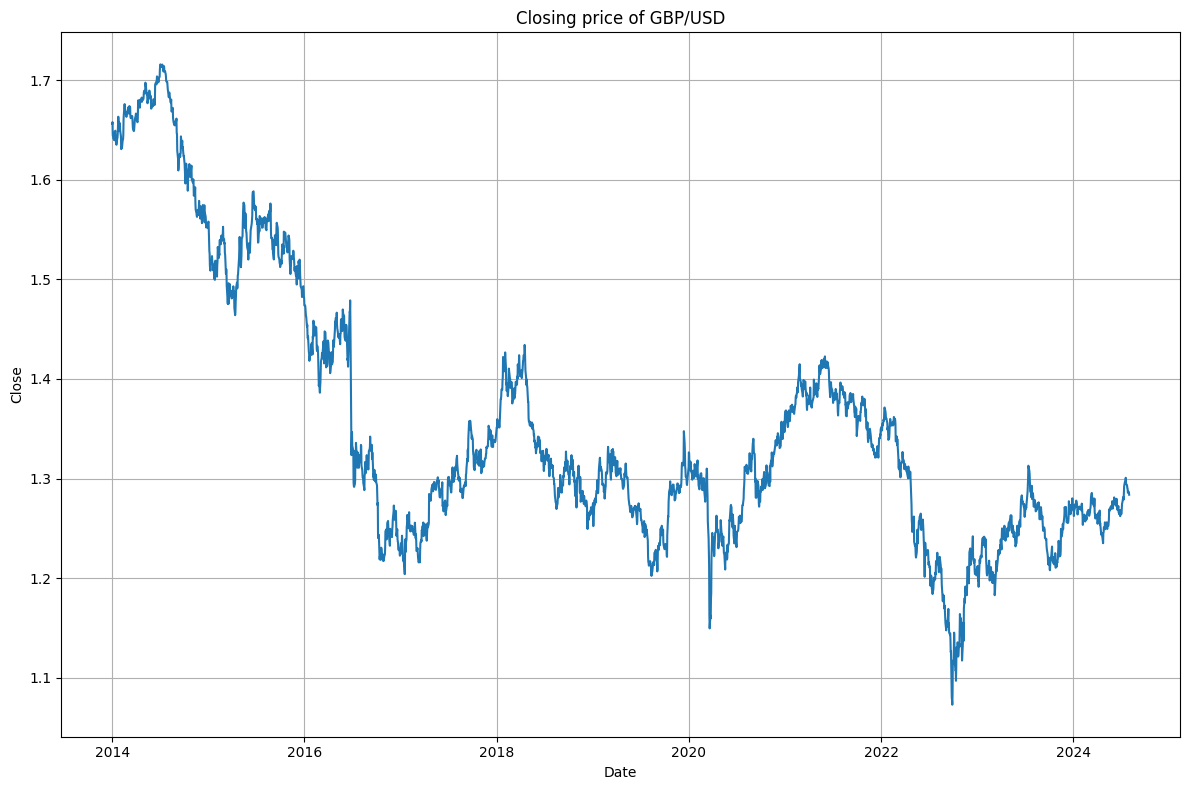

In [162]:
# Plotting closing price
plt.figure(figsize=(12, 8))
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Closing price of GBP/USD')
plt.grid(True)
plt.tight_layout()
plt.show()

### Calculating and plotting rolling averages for GBP/USD closing prices (10, 20, and 50 days)

In [ ]:
df_1 = df.copy()

# Calculating and adding rolling averages
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_1[column_name] = df_1['Close'].rolling(ma).mean()

# Plotting the 'Close' price with the rolling averages
ax = df_1[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(figsize=(12, 8))
ax.set_title('Rolling Average over periods of 10, 20, and 50 days')
ax.set_ylabel('Price')
ax.grid(True)

### Calculating and plotting rolling averages for GBP/USD closing prices (50, 100, and 150 days)

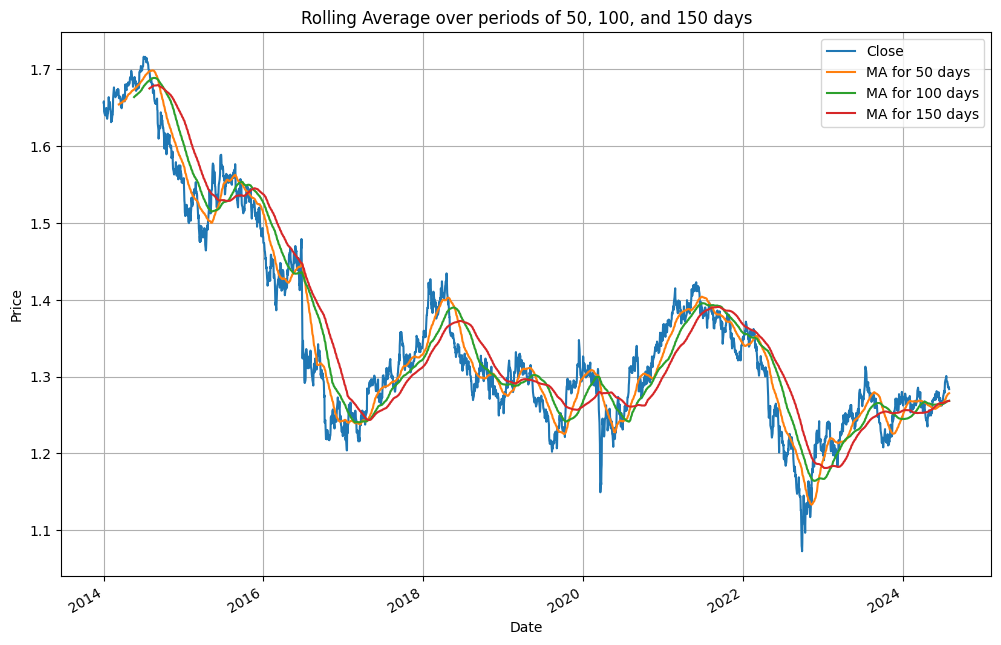

In [130]:
# Calculating and adding rolling averages
ma_day = [50, 100, 150]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_1[column_name] = df_1['Close'].rolling(ma).mean()

# Plotting the 'Close' price with the rolling averages
ax = df_1[['Close', 'MA for 50 days', 'MA for 100 days', 'MA for 150 days']].plot(figsize=(12, 8))
ax.set_title('Rolling Average over periods of 50, 100, and 150 days')
ax.set_ylabel('Price')
ax.grid(True)

### Daily Returns Based on Closing Prices

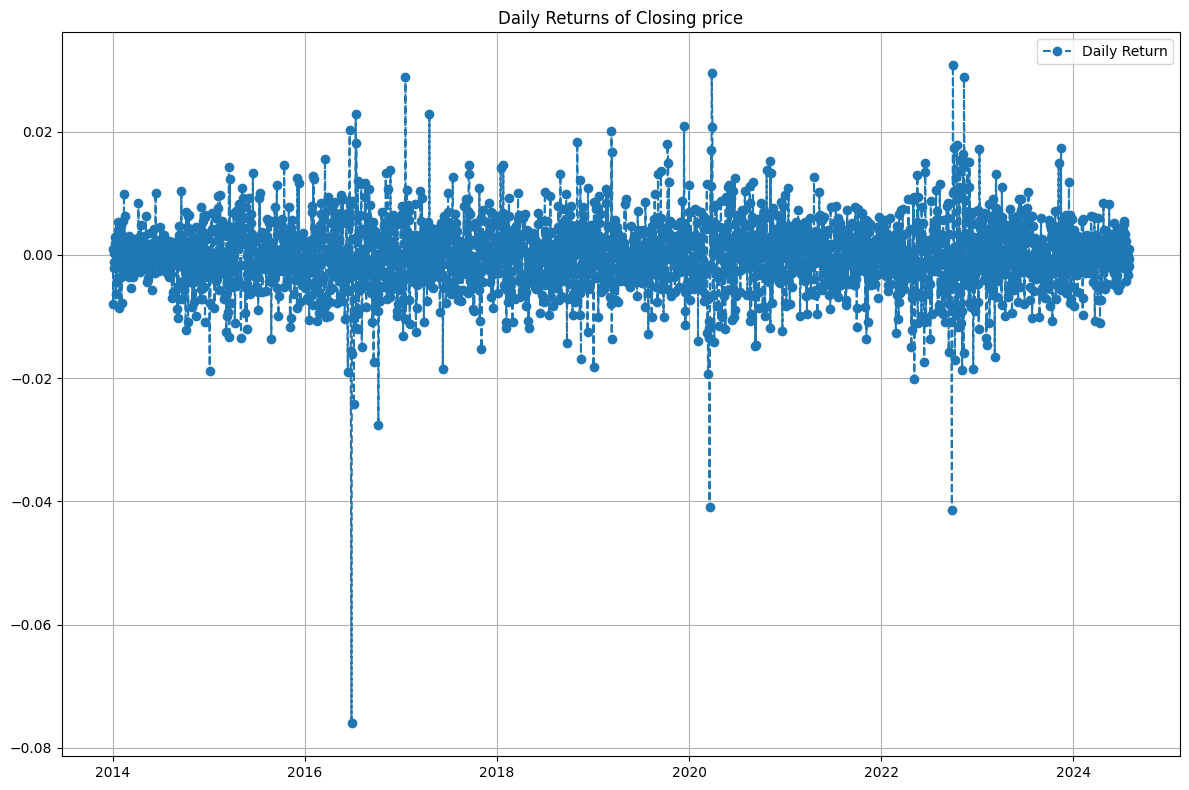

In [131]:
# Calculating the daily returns as the percentage change
plt.figure(figsize=(12, 8))
df_1['Daily Return'] = df_1['Close'].pct_change()
plt.plot(df_1['Daily Return'], linestyle='--', marker='o', label='Daily Return')
plt.title('Daily Returns of Closing price')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Distribution of Close Prices

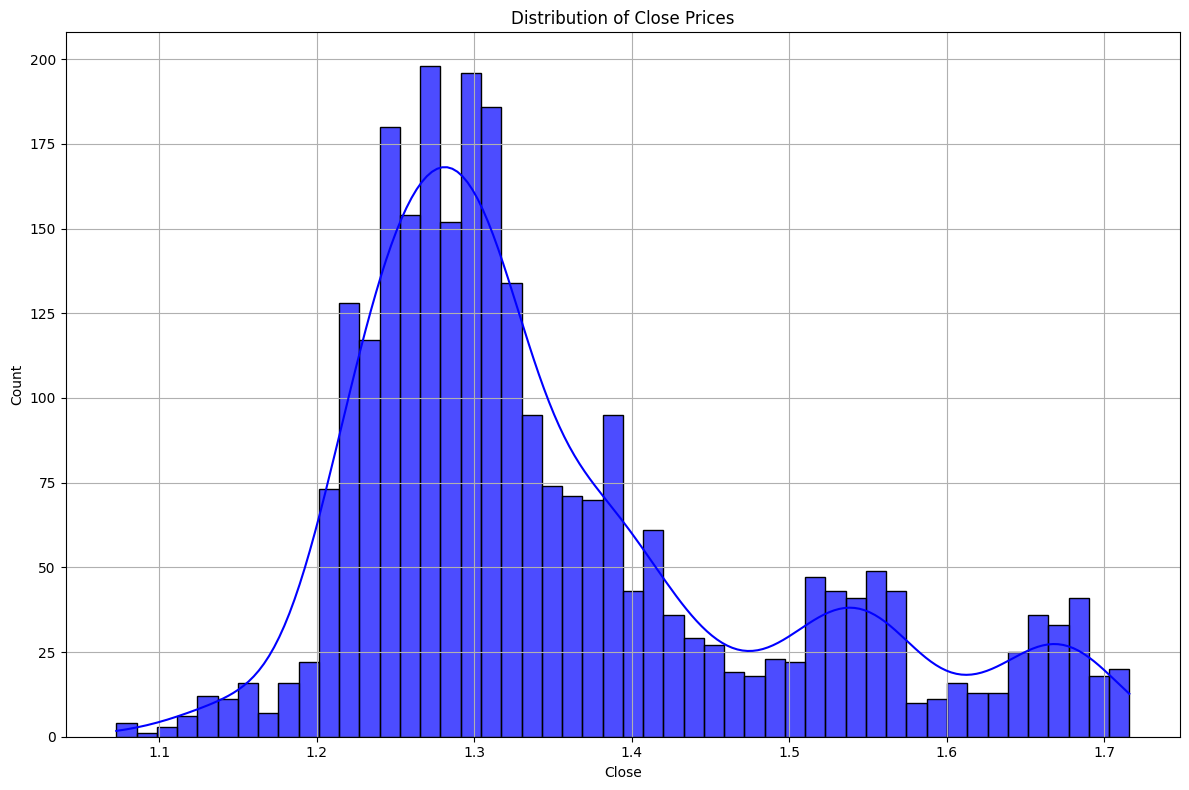

In [132]:
# Plotting the histogram with KDE
plt.figure(figsize=(12, 8))
sns.histplot(df['Close'], kde=True, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Close Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

## Data Cleaning

In [133]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [134]:
df.duplicated().sum()

0

## Data Preprocessing

In [135]:
data = df[['Close']]
data

,Close
Date,
2014-01-01,1.656397
2014-01-02,1.658072
2014-01-03,1.644791
2014-01-06,1.641309
2014-01-07,1.641794
...,...
2024-07-25,1.289990
2024-07-26,1.285678
2024-07-29,1.286836


### Train, Validation, and Test Data Preparation

In [136]:
from sklearn.model_selection import train_test_split
# Training 70% and temporary 30% sets
train_data, temp_data = train_test_split(data, test_size=0.3, shuffle=False)

# Second split: Validation (50% of temp) and test (50% of temp)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

In [137]:
train_data.shape, val_data.shape, test_data.shape

((1930, 1), (414, 1), (414, 1))

In [138]:
print(f"Training set from: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Validation set from: {val_data.index[0]} to {val_data.index[-1]}")
print(f"Testing set from: {test_data.index[0]} to {test_data.index[-1]}")

Training set from: 2014-01-01 00:00:00 to 2021-05-28 00:00:00
Validation set from: 2021-05-31 00:00:00 to 2022-12-29 00:00:00
Testing set from: 2022-12-30 00:00:00 to 2024-07-31 00:00:00


### Scaling the data

In [139]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)
scaled_val_data = scaler.transform(val_data)

In [140]:
# saving the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [141]:
# Defining sequence length
sequence_length = 60

# Creating sequences for the data
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# Generating training, validation, and testing sequences
x_train, y_train = create_sequences(scaled_train_data, sequence_length)
x_val, y_val = create_sequences(scaled_val_data, sequence_length)
x_test, y_test = create_sequences(scaled_test_data, sequence_length)

In [142]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1870, 60), (1870,), (354, 60), (354,), (354, 60), (354,))

In [143]:
# displaying the first 2 rows of the training data
for i in range(2):
 print(x_train[i], y_train[i])

[0.89465643 0.89761283 0.87417454 0.86802907 0.86888508 0.86574881
 0.87403149 0.87967543 0.88236149 0.86394611 0.87174177 0.85897706
 0.85741902 0.86888508 0.86997924 0.87900454 0.89431773 0.90715334
 0.88168955 0.89659441 0.89572198 0.89378506 0.88308203 0.87240929
 0.84965282 0.85346018 0.85284841 0.85195474 0.86755362 0.86726835
 0.87431802 0.90276471 0.91111407 0.92949242 0.92217284 0.91621524
 0.91439844 0.91189792 0.90690909 0.91106505 0.91464395 0.91307413
 0.91724776 0.92380157 0.91307413 0.91282883 0.92202495 0.92602586
 0.92414763 0.9080813  0.90466481 0.90476243 0.9054453  0.90852119
 0.90793488 0.90067274 0.89025707 0.8849085  0.8816418  0.88308203] 0.8891953116683613
[0.89761283 0.87417454 0.86802907 0.86888508 0.86574881 0.87403149
 0.87967543 0.88236149 0.86394611 0.87174177 0.85897706 0.85741902
 0.86888508 0.86997924 0.87900454 0.89431773 0.90715334 0.88168955
 0.89659441 0.89572198 0.89378506 0.88308203 0.87240929 0.84965282
 0.85346018 0.85284841 0.85195474 0.867553

In [144]:
# Reverting the scaled target variables (y_train, y_val, and y_test) back to their original scale
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_original = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

In [145]:
# Defining the evaluation function
def evaluate_model(y_test_original, test_predictions, y_train_original=None, train_predictions=None):
    
    # Train metrics
    if y_train_original is not None and train_predictions is not None:
        print(f'Train MSE: {mean_squared_error(y_train_original, train_predictions)}, '
              f'Train MAE: {mean_absolute_error(y_train_original, train_predictions)}, '
              f'Train R2: {r2_score(y_train_original, train_predictions)}')

    # Test metrics
    mse_test = mean_squared_error(y_test_original, test_predictions)
    mae_test = mean_absolute_error(y_test_original, test_predictions)
    r2_test = r2_score(y_test_original, test_predictions)

    print(f'Test MSE: {mse_test}, Test MAE: {mae_test}, Test R2: {r2_test}')
    
    return mse_test, mae_test, r2_test

# Models Development and Creation:

## Support Vector Regressor Model

### Creating the model

In [153]:
# Defining the SVR model function
def svr_model(kernel = 'rbf', C= 10, gamma= 0.01, epsilon=0.1):
  model = SVR(kernel=kernel, C=C, gamma=gamma, epsilon=epsilon)
  return model

# Creates and train the Support Vector Regressor Model
model = svr_model(kernel='rbf', C= 10, gamma=0.01, epsilon=0.1)
model.fit(x_train, y_train)

# Predicts the model on both train and test set
train_pred_svr = model.predict(x_train)
train_pred_svr = scaler.inverse_transform(train_pred_svr.reshape(-1, 1))

test_pred_svr = model.predict(x_test)
test_pred_svr = scaler.inverse_transform(test_pred_svr.reshape(-1, 1))

# Evaluate the model
evaluate_model(y_test_original, test_pred_svr, y_train_original, train_pred_svr)

Train MSE: 0.0005236523452727339, Train MAE: 0.01915783524483062, Train R2: 0.9696976436928433
Test MSE: 0.00019352710023168805, Test MAE: 0.011538014028775231, Test R2: 0.5304559883449604


(0.00019352710023168805, 0.011538014028775231, 0.5304559883449604)

### Hyperparameter Tuning for Support Vector Regressor

In [117]:
# Initializing the hyperparameters
hyperparameter_sets = {
    'kernel': ['rbf', 'poly', 'linear'],
    'C': [10, 100],
    'gamma': [0.01, 0.005],
    'epsilon': [0.01, 0.1]
}

# Variables for Tracking the Best SVR Model
best_score_svr = float('inf') 
best_params_svr = {}
best_model_svr = None

# Iterating over the hyperparameters
for kernel in hyperparameter_sets['kernel']:
    for C in hyperparameter_sets['C']:
        for gamma in hyperparameter_sets['gamma']:
            for epsilon in hyperparameter_sets['epsilon']:
               # Initialize the Support Vector Regressor
               model = svr_model(kernel, C, gamma, epsilon)

               # Train the model
               model.fit(x_train, y_train)

               # Predictions
               val_predictions = model.predict(x_val) 
                  
               # Inverse transform predictions
               val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1))
                
               # Evaluate the model's performance
               val_mse = mean_squared_error(y_val_original, val_predictions)
               if val_mse < best_score_svr: 
                  best_score_svr = val_mse  
                  best_params_svr = {'kernel': kernel, 'C': C, 'gamma': gamma, 'epsilon': epsilon}
                  best_model_svr = model

In [118]:
print(f"Best parameters for Support Vector Regressor: {best_params_svr}")

Best parameters for Support Vector Regressor: {'kernel': 'linear', 'C': 10, 'gamma': 0.01, 'epsilon': 0.01}


In [119]:
# Evaluating the best performing svr model on the training and testing set
best_train_pred_svr = best_model_svr.predict(x_train)
best_train_pred_svr = scaler.inverse_transform(best_train_pred_svr.reshape(-1, 1))

best_test_pred_svr = best_model_svr.predict(x_test)
best_test_pred_svr = scaler.inverse_transform(best_test_pred_svr.reshape(-1, 1))

evaluate_model(y_test_original, best_test_pred_svr, y_train_original, best_train_pred_svr)

Train MSE: 5.960710938207964e-05, Train MAE: 0.005612304836389409, Train R2: 0.993350566372604
Test MSE: 2.6012558119503207e-05, Test MAE: 0.0040587335430499576, Test R2: 0.8626553008638941


(2.6012558119503207e-05, 0.0040587335430499576, 0.8626553008638941)

### Saving the best SVR model

In [245]:
# Saving the best performing model
joblib.dump(best_model_svr, 'Best_SVR_Model.pkl')

['models/Best_SVR_Model.pkl']

### Visualizing Test vs. Predicted Values for SVR

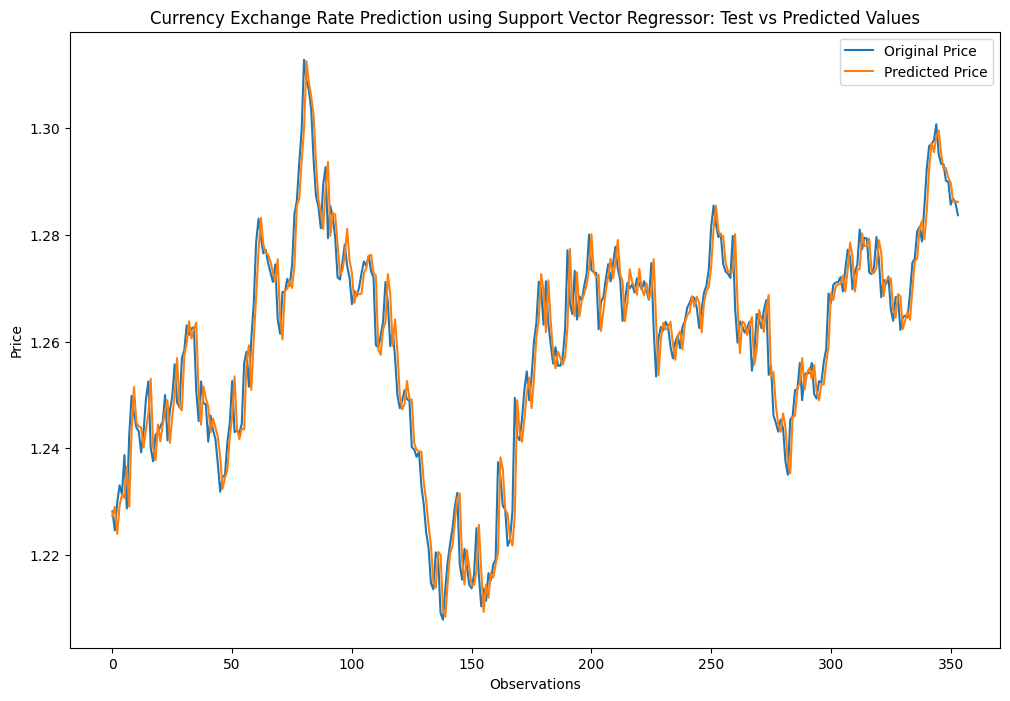

In [246]:
# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(y_test_original, label='Original Price')
plt.plot(best_test_pred_svr, label='Predicted Price')
plt.title(f'Currency Exchange Rate Prediction using Support Vector Regressor: Test vs Predicted Values')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

## Random Forest Regressor Model

### Creating the model

In [247]:
# Defining the Random Forest Model Function
def rf_model(n_estimators = 50, max_depth = None, min_samples_split = 2):
  model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
  return model

# Creates and train the Random Forest Model
model = rf_model(n_estimators=50, max_depth=None, min_samples_split=2)
model.fit(x_train, y_train)

# Predicts the model on both train and test
train_pred_rf = model.predict(x_train)
train_pred_rf = scaler.inverse_transform(train_pred_rf.reshape(-1, 1))

test_pred_rf = model.predict(x_test)
test_pred_rf = scaler.inverse_transform(test_pred_rf.reshape(-1, 1))

# Evaluate the model
evaluate_model(y_test_original, test_pred_rf, y_train_original, train_pred_rf)

Train MSE: 1.0531673987709174e-05, Train MAE: 0.0022434989551809352, Train R2: 0.9993905602818982
Test MSE: 3.4384448057753065e-05, Test MAE: 0.0045336233491951455, Test R2: 0.9165749310548594


(3.4384448057753065e-05, 0.0045336233491951455, 0.9165749310548594)

### Hyperparameter Tuning for Random Forest Regressor

In [248]:
# Initializing the hyperparameters
hyperparameter_sets = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 10, 15],
}

best_score_rf = float('inf') 
best_params_rf = {}
best_model_rf = None

for n_estimators in hyperparameter_sets['n_estimators']:
    for max_depth in hyperparameter_sets['max_depth']:
        for min_samples_split in hyperparameter_sets['min_samples_split']:
            
            # Initialize the RandomForest model
            model = rf_model(n_estimators, max_depth, min_samples_split)

            # Train the model
            model.fit(x_train, y_train)

            # Predictions
            val_predictions = model.predict(x_val)
            
            # Inverse transform predictions
            val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1))
                
            # Evaluate the model's performance
            val_mse = mean_squared_error(y_val_original, val_predictions)
            if val_mse < best_score_rf: 
                best_score_rf = val_mse  
                best_params_rf = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
                best_model_rf = model

In [249]:
print(f"Best parameters for Random Forest Regressor: {best_params_rf}")

Best parameters for Random Forest Regressor: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 15}


In [250]:
# Evaluating the best performing rf model on the training and testing set
best_train_pred_rf = best_model_rf.predict(x_train)
best_train_pred_rf = scaler.inverse_transform(best_train_pred_rf.reshape(-1, 1))

best_test_pred_rf = best_model_rf.predict(x_test)
best_test_pred_rf = scaler.inverse_transform(best_test_pred_rf.reshape(-1, 1))

# Evaluate the model
evaluate_model(y_test_original, best_test_pred_rf, y_train_original, best_train_pred_rf)

Train MSE: 2.1931340996505196e-05, Train MAE: 0.0034431249483695817, Train R2: 0.998730892136416
Test MSE: 3.2220279531460465e-05, Test MAE: 0.004356991854449435, Test R2: 0.9218257324698367


(3.2220279531460465e-05, 0.004356991854449435, 0.9218257324698367)

### Saving the best Random Forest model

In [251]:
# Saving the best RF model
joblib.dump(best_model_rf, 'Best_RF_Model.pkl')

['models/Best_RF_Model.pkl']

### Visualizing Test vs. Predicted Values for RF

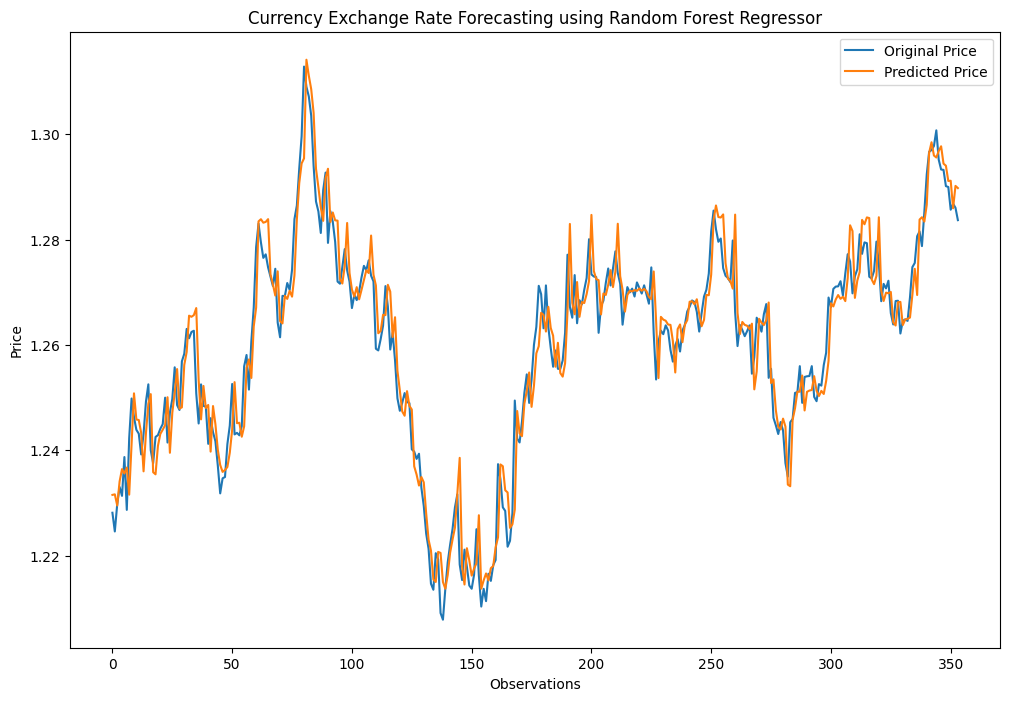

In [252]:
# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(y_test_original, label='Original Price')
plt.plot(best_test_pred_rf, label='Predicted Price')
plt.title(f'Currency Exchange Rate Forecasting using Random Forest Regressor')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

## Artificial Neural Network Models

### Multi-layer Perceptron Neural Network

#### Creating the model

In [253]:
from keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitoring the validation loss
    patience=20,         # Number of epochs with no improvement to stop training
    restore_best_weights=True  # Restoring the weights of the best epoch
)

In [254]:
# Defining the Multi-layer Perceptron Neural Network Model Function
def mlp_model(units_1 = 50, units_2 = None):
  model = Sequential()
  model.add(Dense(units=units_1, activation='relu', input_dim=60))
  if units_2:
    model.add(Dense(units=units_2, activation='relu'))
  model.add(Dense(units=1))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  return model

In [255]:
# Model 1: MLP with 50 units
mlp1 = mlp_model(units_1=50)
mlp1_history = mlp1.fit(x_train, y_train, validation_data=(x_val, y_val),  
    epochs=500,
    callbacks=[early_stopping])

# Prediction on train set
train_pred_mlp1 = mlp1.predict(x_train)
train_pred_mlp1 = scaler.inverse_transform(train_pred_mlp1.reshape(-1, 1))

# Prediction on test set
test_pred_mlp1 = mlp1.predict(x_test)
test_pred_mlp1 = scaler.inverse_transform(test_pred_mlp1.reshape(-1, 1))

# Evaluating the model
evaluate_model(y_test_original, test_pred_mlp1, y_train_original, train_pred_mlp1)

Epoch 1/500
59/59 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 2/500
59/59 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/500
59/59 [==============================] - 0s 2ms/step - loss: 8.8477e-04 - val_loss: 0.0014
Epoch 4/500
59/59 [==============================] - 0s 2ms/step - loss: 8.2427e-04 - val_loss: 0.0015
Epoch 5/500
59/59 [==============================] - 0s 2ms/step - loss: 9.8030e-04 - val_loss: 0.0012
Epoch 6/500
59/59 [==============================] - 0s 2ms/step - loss: 6.5904e-04 - val_loss: 0.0011
Epoch 7/500
59/59 [==============================] - 0s 2ms/step - loss: 7.2945e-04 - val_loss: 0.0011
Epoch 8/500
59/59 [==============================] - 0s 2ms/step - loss: 6.4100e-04 - val_loss: 0.0010
Epoch 9/500
59/59 [==============================] - 0s 2ms/step - loss: 6.0775e-04 - val_loss: 0.0015
Epoch 10/500
59/59 [==============================] - 0s 2ms/step - loss: 8.1146e

(3.1302197879358305e-05, 0.004295569691954354, 0.9240532227874142)

### Experimenting with different parameters

In [256]:
# Model 2: mlp with 100 units
mlp2 = mlp_model(units_1=100)
mlp2_history = mlp2.fit(x_train, y_train, validation_data=(x_val, y_val),  
    epochs=500,
    callbacks=[early_stopping])

# Prediction on train set
train_pred_mlp2 = mlp2.predict(x_train)
train_pred_mlp2 = scaler.inverse_transform(train_pred_mlp2.reshape(-1, 1))

# Prediction on test set
test_pred_mlp2 = mlp2.predict(x_test)
test_pred_mlp2 = scaler.inverse_transform(test_pred_mlp2.reshape(-1, 1))

# Evaluating the model
evaluate_model(y_test_original, test_pred_mlp2, y_train_original, train_pred_mlp2)

Epoch 1/500
59/59 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0023
Epoch 2/500
59/59 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 3/500
59/59 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 4/500
59/59 [==============================] - 0s 2ms/step - loss: 9.4883e-04 - val_loss: 0.0014
Epoch 5/500
59/59 [==============================] - 0s 2ms/step - loss: 8.4817e-04 - val_loss: 0.0013
Epoch 6/500
59/59 [==============================] - 0s 2ms/step - loss: 8.0006e-04 - val_loss: 0.0014
Epoch 7/500
59/59 [==============================] - 0s 2ms/step - loss: 7.6024e-04 - val_loss: 0.0012
Epoch 8/500
59/59 [==============================] - 0s 2ms/step - loss: 8.0740e-04 - val_loss: 0.0012
Epoch 9/500
59/59 [==============================] - 0s 2ms/step - loss: 6.5298e-04 - val_loss: 0.0011
Epoch 10/500
59/59 [==============================] - 0s 2ms/step - loss: 6.2598e-04 

(3.028502593168354e-05, 0.004324884401202867, 0.9265211303635749)

In [257]:
# Model 3: mlp with 2 hidden layers: 100 units in the first layer and 50 units in the second layer
mlp3 = mlp_model(units_1=100, units_2=50)
mlp3_history = mlp3.fit(x_train, y_train, validation_data=(x_val, y_val), 
    epochs=500,
    callbacks=[early_stopping])

# Prediction on train set
train_pred_mlp3 = mlp3.predict(x_train)
train_pred_mlp3 = scaler.inverse_transform(train_pred_mlp3.reshape(-1, 1))

# Prediction on test set
test_pred_mlp3 = mlp3.predict(x_test)
test_pred_mlp3 = scaler.inverse_transform(test_pred_mlp3.reshape(-1, 1))

# Evaluating the model
evaluate_model(y_test_original, test_pred_mlp3, y_train_original, train_pred_mlp3)

Epoch 1/500
59/59 [==============================] - 1s 3ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 2/500
59/59 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 3/500
59/59 [==============================] - 0s 2ms/step - loss: 8.9006e-04 - val_loss: 0.0014
Epoch 4/500
59/59 [==============================] - 0s 2ms/step - loss: 7.1907e-04 - val_loss: 0.0016
Epoch 5/500
59/59 [==============================] - 0s 2ms/step - loss: 7.0108e-04 - val_loss: 0.0012
Epoch 6/500
59/59 [==============================] - 0s 2ms/step - loss: 6.2586e-04 - val_loss: 0.0011
Epoch 7/500
59/59 [==============================] - 0s 2ms/step - loss: 6.5509e-04 - val_loss: 0.0011
Epoch 8/500
59/59 [==============================] - 0s 2ms/step - loss: 5.2074e-04 - val_loss: 0.0011
Epoch 9/500
59/59 [==============================] - 0s 2ms/step - loss: 6.2517e-04 - val_loss: 0.0011
Epoch 10/500
59/59 [==============================] - 0s 2ms/step - loss: 4.9248e

(4.090085458392993e-05, 0.004960420441492798, 0.9007645372742825)

### Training Loss Visualization for the best MLP Model

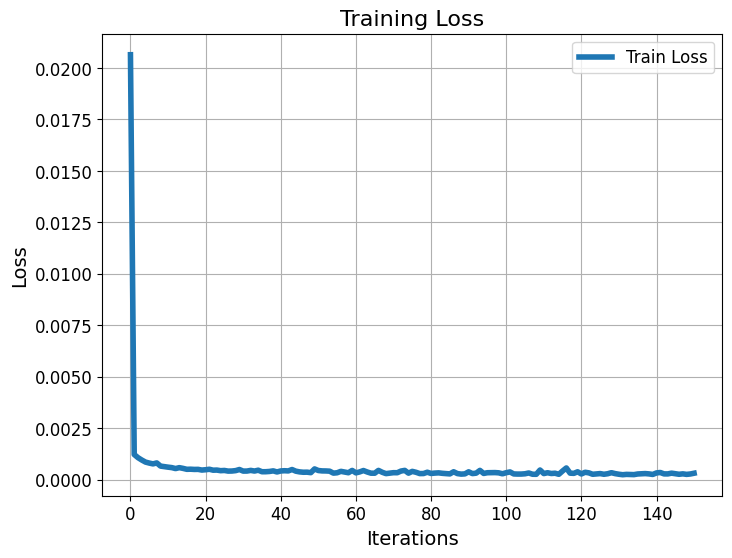

In [258]:
# Plotting the training loss
plt.figure(figsize=(8, 6))  
plt.plot(mlp2_history.history['loss'], label='Train Loss', linewidth=4) 
plt.title('Training Loss', fontsize=16) 
plt.xlabel('Iterations', fontsize=14)  
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)  
plt.grid(True)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.show()

### Saving the best MLP model

In [259]:
# Saving the best MLP model
mlp2.save('Best_MLP_Model.h5')

### Visualizing Test vs. Predicted Values for MLP

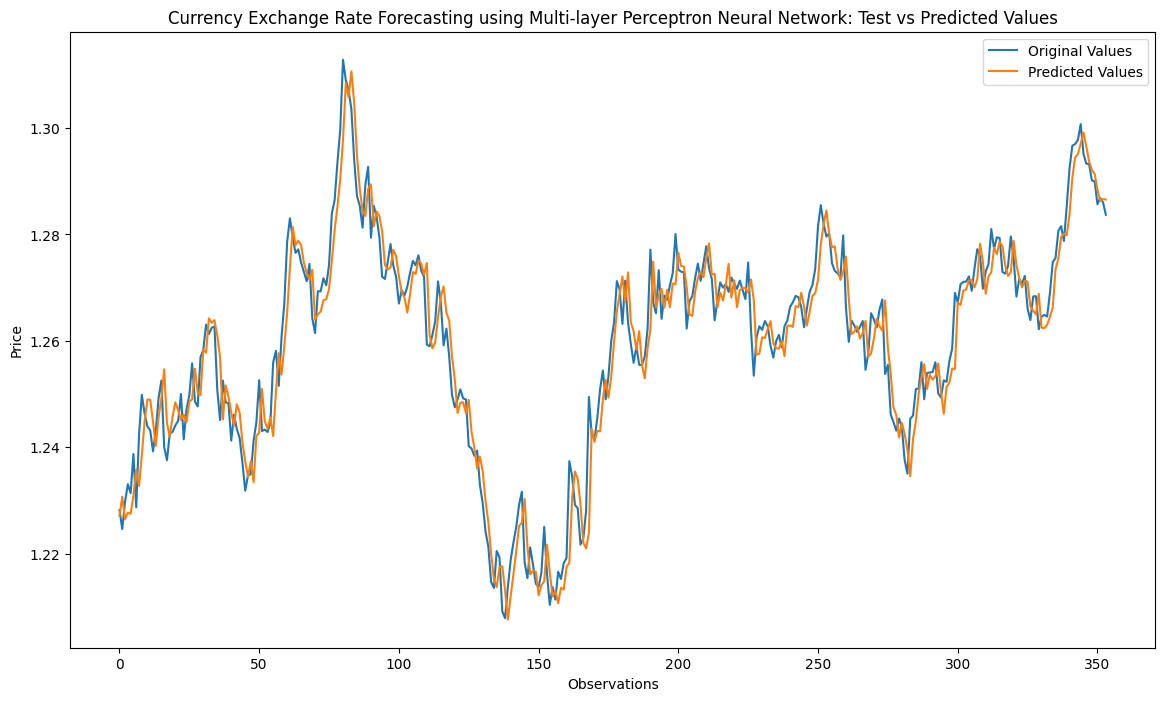

In [260]:
# Plotting the result
plt.figure(figsize=(14, 8))
plt.plot(y_test_original, label='Original Values')
plt.plot(test_pred_mlp2, label='Predicted Values')
plt.title(f'Currency Exchange Rate Forecasting using Multi-layer Perceptron Neural Network: Test vs Predicted Values')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

## Convolutional Neural Network (CNN)

### Preparing Input Data for CNN by reshaping it to 3D Format

In [261]:
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
X_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [262]:
X_train.shape

(1870, 60, 1)

In [263]:
X_test.shape

(354, 60, 1)

In [264]:
X_val.shape

(354, 60, 1)

### Creating the model

In [265]:
def cnn_model(filters=32, kernel_size=3, pool_size=2, unit_1 = 50, unit_2 = None):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(60, 1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(units=unit_1, activation='relu'))
    if unit_2:
       model.add(Dense(units=unit_2, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [266]:
# Model 1: CNN with 50 units and 32 filters
cnn1 = cnn_model(filters=32, kernel_size=3, pool_size=2, unit_1=50)
cnn1_history = cnn1.fit(X_train, y_train, validation_data=(X_val, y_val), 
    epochs=100,
    callbacks=[early_stopping])

# Predictions on train set
train_pred_cnn1 = cnn1.predict(X_train)
train_pred_cnn1 = scaler.inverse_transform(train_pred_cnn1.reshape(-1, 1))

# Predictions on test set
test_pred_cnn1 = cnn1.predict(X_test)
test_pred_cnn1 = scaler.inverse_transform(test_pred_cnn1.reshape(-1, 1))

# Evaluating the model
evaluate_model(y_test_original, test_pred_cnn1, y_train_original, train_pred_cnn1)

Epoch 1/100
59/59 [==============================] - 1s 5ms/step - loss: 0.0130 - val_loss: 0.0029
Epoch 2/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/100
59/59 [==============================] - 0s 3ms/step - loss: 7.9950e-04 - val_loss: 7.5770e-04
Epoch 5/100
59/59 [==============================] - 0s 3ms/step - loss: 6.3479e-04 - val_loss: 6.9414e-04
Epoch 6/100
59/59 [==============================] - 0s 3ms/step - loss: 5.6525e-04 - val_loss: 6.9317e-04
Epoch 7/100
59/59 [==============================] - 0s 3ms/step - loss: 5.3483e-04 - val_loss: 5.8306e-04
Epoch 8/100
59/59 [==============================] - 0s 3ms/step - loss: 4.9556e-04 - val_loss: 5.6838e-04
Epoch 9/100
59/59 [==============================] - 0s 2ms/step - loss: 4.4130e-04 - val_loss: 5.8937e-04
Epoch 10/100
59/59 [==============================] - 0s 2ms/

(4.12912253749895e-05, 0.004991579527235289, 0.8998174023921517)

### Experimenting with different parameters

In [267]:
# Model 2: CNN with 50 units and 64 filters
cnn2 = cnn_model(filters=64, kernel_size=3, pool_size=2, unit_1=50)
cnn2_history = cnn2.fit(X_train, y_train, validation_data=(X_val, y_val), 
    epochs=100,
    callbacks=[early_stopping])

# Predictions on train set
train_pred_cnn2 = cnn2.predict(X_train)
train_pred_cnn2 = scaler.inverse_transform(train_pred_cnn2.reshape(-1, 1))

# Predictions on test set
test_pred_cnn2 = cnn2.predict(X_test)
test_pred_cnn2 = scaler.inverse_transform(test_pred_cnn2.reshape(-1, 1))

# Evaluating the model
evaluate_model(y_test_original, test_pred_cnn2, y_train_original, train_pred_cnn2)

Epoch 1/100
59/59 [==============================] - 1s 5ms/step - loss: 0.0123 - val_loss: 0.0025
Epoch 2/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 4/100
59/59 [==============================] - 0s 3ms/step - loss: 9.9776e-04 - val_loss: 9.4414e-04
Epoch 5/100
59/59 [==============================] - 0s 3ms/step - loss: 7.1250e-04 - val_loss: 9.2816e-04
Epoch 6/100
59/59 [==============================] - 0s 3ms/step - loss: 6.2555e-04 - val_loss: 7.6423e-04
Epoch 7/100
59/59 [==============================] - 0s 3ms/step - loss: 6.4320e-04 - val_loss: 8.0187e-04
Epoch 8/100
59/59 [==============================] - 0s 3ms/step - loss: 5.4066e-04 - val_loss: 9.0718e-04
Epoch 9/100
59/59 [==============================] - 0s 3ms/step - loss: 4.3115e-04 - val_loss: 8.3342e-04
Epoch 10/100
59/59 [==============================] - 0s 3ms/

(5.161732413633477e-05, 0.005639361459656616, 0.8747637647809666)

In [268]:
# Model 3: CNN with 100 units and 64 filters
cnn3 = cnn_model(filters=64, kernel_size=3, pool_size=2, unit_1=100)
cnn3_history = cnn3.fit(X_train, y_train, validation_data=(X_val, y_val), 
    epochs=100,
    callbacks=[early_stopping])

# Predictions on train set
train_pred_cnn3 = cnn3.predict(X_train)
train_pred_cnn3 = scaler.inverse_transform(train_pred_cnn3.reshape(-1, 1))

# Predictions on test set
test_pred_cnn3 = cnn3.predict(X_test)
test_pred_cnn3 = scaler.inverse_transform(test_pred_cnn3.reshape(-1, 1))

# Evaluating the model
evaluate_model(y_test_original, test_pred_cnn3, y_train_original, train_pred_cnn3)

Epoch 1/100
59/59 [==============================] - 1s 7ms/step - loss: 0.0057 - val_loss: 0.0016
Epoch 2/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/100
59/59 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 4/100
59/59 [==============================] - 0s 5ms/step - loss: 8.8360e-04 - val_loss: 0.0015
Epoch 5/100
59/59 [==============================] - 0s 4ms/step - loss: 8.1260e-04 - val_loss: 0.0017
Epoch 6/100
59/59 [==============================] - 0s 5ms/step - loss: 6.4284e-04 - val_loss: 0.0013
Epoch 7/100
59/59 [==============================] - 0s 5ms/step - loss: 5.9158e-04 - val_loss: 0.0013
Epoch 8/100
59/59 [==============================] - 0s 4ms/step - loss: 5.6124e-04 - val_loss: 0.0015
Epoch 9/100
59/59 [==============================] - 0s 5ms/step - loss: 4.6878e-04 - val_loss: 0.0013
Epoch 10/100
59/59 [==============================] - 0s 5ms/step - loss: 4.3301e-04 

(4.203053387597205e-05, 0.005130992434119091, 0.898023659402222)

In [269]:
# Model 4: CNN with 100 and 50 hidden units and 64 filters
cnn4 = cnn_model(filters=64, kernel_size=3, pool_size=2, unit_1=100, unit_2=50)
cnn4_history = cnn4.fit(X_train, y_train, validation_data=(X_val, y_val),  
    epochs=100,
    callbacks=[early_stopping])

# Predictions on train set
train_pred_cnn4 = cnn4.predict(X_train)
train_pred_cnn4 = scaler.inverse_transform(train_pred_cnn4.reshape(-1, 1))

# Predictions on test set
test_pred_cnn4 = cnn4.predict(X_test)
test_pred_cnn4 = scaler.inverse_transform(test_pred_cnn4.reshape(-1, 1))

# Evaluating the model
evaluate_model(y_test_original, test_pred_cnn4, y_train_original, train_pred_cnn4)

Epoch 1/100
59/59 [==============================] - 1s 6ms/step - loss: 0.0132 - val_loss: 0.0027
Epoch 2/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 4/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 5/100
59/59 [==============================] - 0s 3ms/step - loss: 8.2870e-04 - val_loss: 0.0021
Epoch 6/100
59/59 [==============================] - 0s 3ms/step - loss: 6.8553e-04 - val_loss: 0.0018
Epoch 7/100
59/59 [==============================] - 0s 3ms/step - loss: 6.1279e-04 - val_loss: 0.0021
Epoch 8/100
59/59 [==============================] - 0s 3ms/step - loss: 5.7579e-04 - val_loss: 0.0020
Epoch 9/100
59/59 [==============================] - 0s 3ms/step - loss: 4.5792e-04 - val_loss: 0.0020
Epoch 10/100
59/59 [==============================] - 0s 3ms/step - loss: 4.7228e-04 - va

(5.405203680041128e-05, 0.00581026515044734, 0.8688565572108166)

### Saving the best CNN model

In [270]:
# Saving the best CNN model
cnn1.save('Best_CNN_Model.h5')

### Visualizing Test vs. Predicted Values for CNN

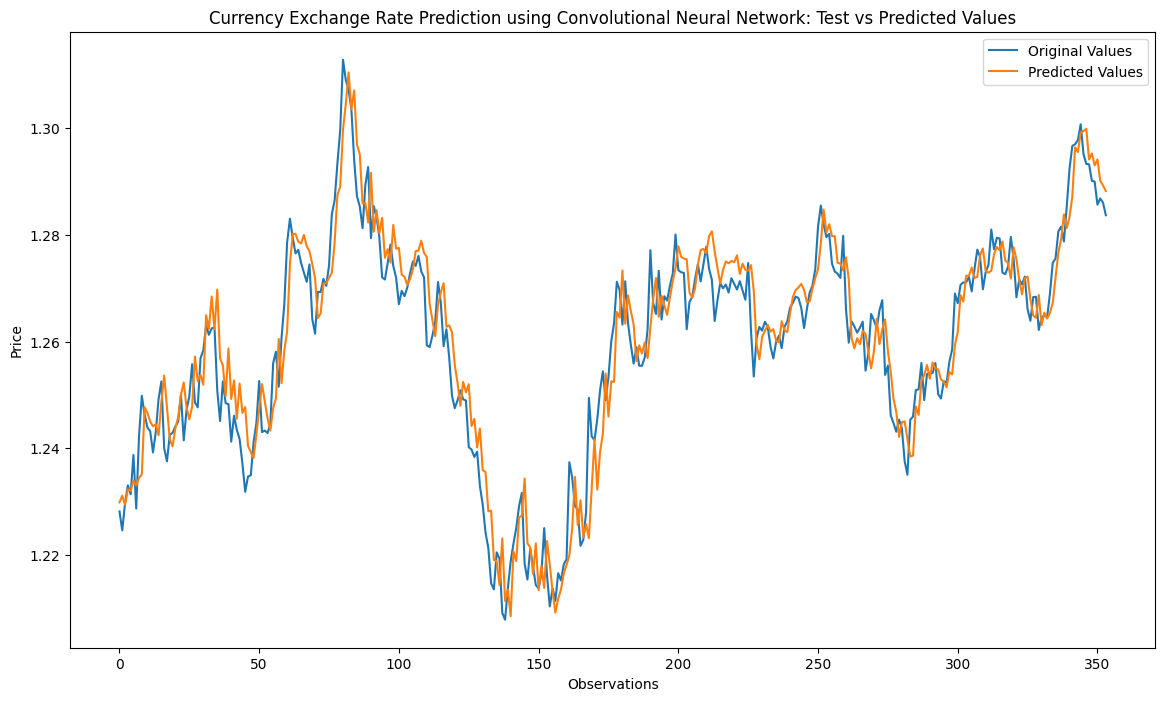

In [271]:
# Plotting the result
plt.figure(figsize=(14, 8))
plt.plot(y_test_original, label='Original Values')
plt.plot(test_pred_cnn1, label='Predicted Values')
plt.title(f'Currency Exchange Rate Prediction using Convolutional Neural Network: Test vs Predicted Values')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

### Training Loss Visualization for the best CNN Model

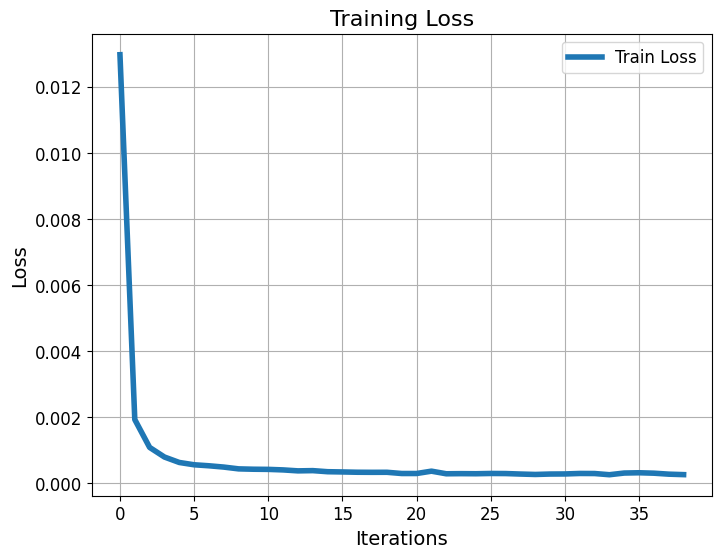

In [272]:
# Plotting the training loss
plt.figure(figsize=(8, 6))  
plt.plot(cnn1_history.history['loss'], label='Train Loss', linewidth=4) 
plt.title('Training Loss', fontsize=16) 
plt.xlabel('Iterations', fontsize=14)  
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)  
plt.grid(True)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.show()

## Performance Evaluation of the Best Performing Models:

In [276]:
# Loading the best performing models
def load_models():
    svr_model = joblib.load('Best_SVR_Model.pkl')
    rf_model = joblib.load('Best_RF_Model.pkl')
    mlp_model = load_model('Best_MLP_Model.h5')
    cnn_model = load_model('Best_CNN_Model.h5')
    return svr_model, rf_model, mlp_model, cnn_model


best_svr_model, best_rf_model, best_mlp_model, best_cnn_model = load_models()

In [277]:
# Predicting on test set.
best_test_pred_svr = best_svr_model.predict(x_test)
best_test_pred_svr = scaler.inverse_transform(best_test_pred_svr.reshape(-1, 1))

best_test_pred_rf = best_rf_model.predict(x_test)
best_test_pred_rf = scaler.inverse_transform(best_test_pred_rf.reshape(-1, 1)) 

best_test_pred_mlp = best_mlp_model.predict(x_test)
best_test_pred_mlp = scaler.inverse_transform(best_test_pred_mlp.reshape(-1, 1))

best_test_pred_cnn = best_cnn_model.predict(X_test)
best_test_pred_cnn = scaler.inverse_transform(best_test_pred_cnn.reshape(-1, 1))


# Evaluating the best performing models
print("Evaluating SVR Model:")
best_svr_test_mse, best_svr_test_mae, best_svr_test_r2 = evaluate_model(y_test_original, best_test_pred_svr)
print("\nEvaluating RF Model:")
best_rf_test_mse, best_rf_test_mae, best_rf_test_r2 = evaluate_model(y_test_original, best_test_pred_rf)
print("\nEvaluating MLP Model:")
best_mlp_test_mse, best_mlp_test_mae, best_mlp_test_r2 = evaluate_model(y_test_original, best_test_pred_mlp)
print("\nEvaluating CNN Model:")
best_cnn_test_mse, best_cnn_test_mae, best_cnn_test_r2 = evaluate_model(y_test_original, best_test_pred_cnn)

12/12 [==============================] - 0s 1ms/step
Evaluating SVR Model:
Test MSE: 2.8100138157469116e-05, Test MAE: 0.004055551713981793, Test R2: 0.931822201734419

Evaluating RF Model:
Test MSE: 3.2220279531460465e-05, Test MAE: 0.004356991854449435, Test R2: 0.9218257324698367

Evaluating MLP Model:
Test MSE: 3.028502593168354e-05, Test MAE: 0.004324884401202867, Test R2: 0.9265211303635749

Evaluating CNN Model:
Test MSE: 4.12912253749895e-05, Test MAE: 0.004991579527235289, Test R2: 0.8998174023921517


### Comparison of MSE across SVR, RF, MLP and CNN

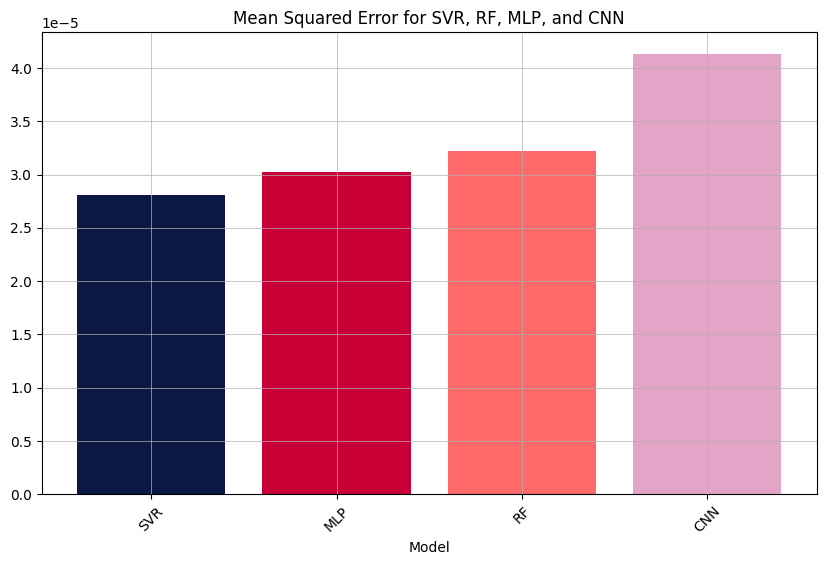

In [278]:
mse_values = {
    'SVR': best_svr_test_mse,
    'RF': best_rf_test_mse,
    'MLP': best_mlp_test_mse,
    'CNN': best_cnn_test_mse
}

sorted_models = sorted(mse_values.items(), key=lambda item: item[1])
models, mse_values_list = zip(*sorted_models)
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values_list, color=['#0C1844', '#C80036', '#FF6969', '#E3A5C7'])
plt.xticks(rotation=45)
plt.title('Mean Squared Error for SVR, RF, MLP, and CNN')
plt.xlabel('Model')
plt.grid(True, linestyle='-', linewidth=0.5)

### Comparison of MAE across SVR, RF, MLP and CNN

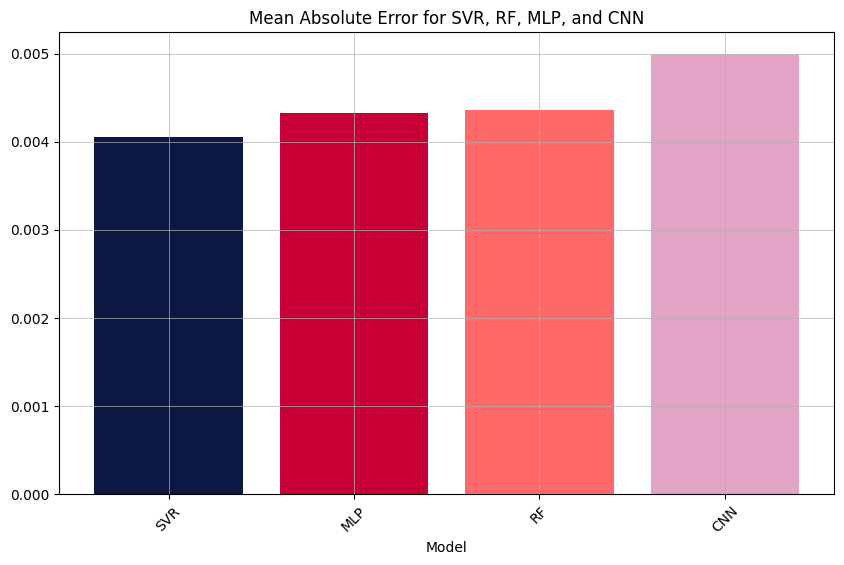

In [279]:
mae_values = {
    'SVR': best_svr_test_mae,
    'RF': best_rf_test_mae,
    'MLP': best_mlp_test_mae,
    'CNN': best_cnn_test_mae
}

sorted_models = sorted(mae_values.items(), key=lambda item: item[1])
models, mae_values_list = zip(*sorted_models)
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values_list, color=['#0C1844', '#C80036', '#FF6969', '#E3A5C7'])
plt.xticks(rotation=45)
plt.title('Mean Absolute Error for SVR, RF, MLP, and CNN')
plt.xlabel('Model')
plt.grid(True, linestyle='-', linewidth=0.5)

### Comparison of R² Values across SVR, RF, MLP and CNN

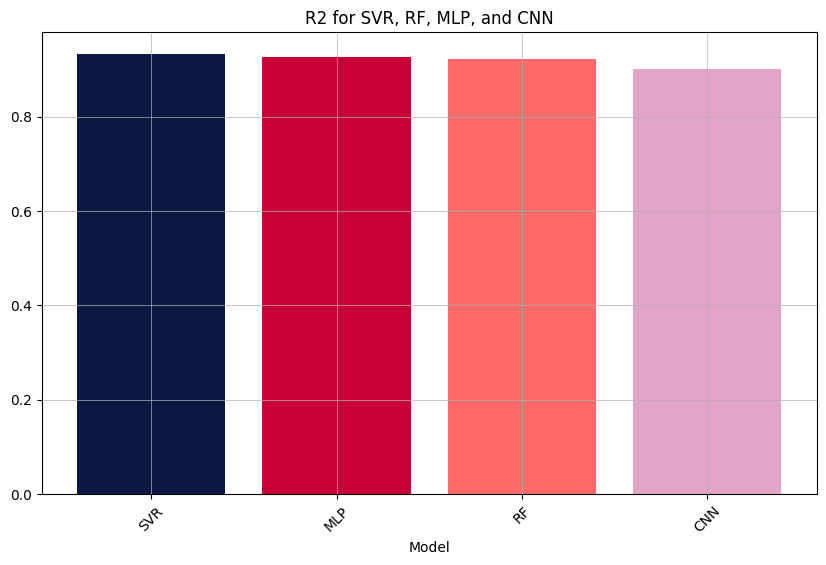

In [280]:
r2_values = {
    'SVR': best_svr_test_r2,
    'RF': best_rf_test_r2,
    'MLP': best_mlp_test_r2,
    'CNN': best_cnn_test_r2
}

sorted_models = sorted(r2_values.items(), key=lambda item: item[1], reverse=True)
models, r2_values_list = zip(*sorted_models)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values_list, color=['#0C1844', '#C80036', '#FF6969', '#E3A5C7'])
plt.xticks(rotation=45)
plt.title('R2 for SVR, RF, MLP, and CNN')
plt.xlabel('Model')
plt.grid(True, linestyle='-', linewidth=0.5)